In [1]:
#!pip install apyori

In [2]:
#import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.metrics.pairwise import cosine_similarity
from apyori import apriori
import time

## 1. Creation of a table of destinations and their attractions
The idea here is to create a list of cities and give them a random number of activities from a list of different categories. The distribution of number of activities per city will be lognormal, i. e., few cities will have a very low number and there will be fewer cities as this number increases, while most of them will be around the mode. The activities will be randomly put into one of the categories, with equal probabilities.

### 1.1 Creating the cities
The first idea was to name the cities as 'City_###', but I found a list of fictional locations from games, books, series and movies, so that will be more interesting. I'm using BeautifulSoup to read the website and extract the names of the cities.

In [3]:
#get list of fictional cities from website
#url_cities = 'https://list.fandom.com/wiki/List_of_fictional_cities'
#html_data=requests.get(url_cities).text
#soup = BeautifulSoup(html_data,"html5lib") 

#local version
soup = BeautifulSoup(open("list_fictional_cities.html", encoding="utf8"), "html.parser")


#getting the list from the HTML
list_cities=[]
html_text=soup.findAll('li')[81:-51]
for row in html_text:
    list_cities.append(row.text)

list_cities = [x.split(' - ')[0].split(',')[0].split(';')[0].split('(')[0] for x in list_cities]
#removing empty entries
list_cities = list(filter(None, list_cities))

#editing special cases (typos from the website)
list_special = ['Emmerdale from the British TV series of the same name','Capitol City the capital of the United States of America featured in the game Destroy All Humans! which is based on Washington DC.',
                "Walton's Mountain fictional site in the Blue Ridge Mountains for The Waltons","El-Ysa: village in Klatch in Terry Pratchett's Discworld. The inhabitants were killed when their well was poisoned ",
               "Kamurocho- A fictional city in the Yakuza series", "Everville -town on the West Coast of the USA in Clive Barker's Everville",
               "Earth City in Inverted World by Christopher Priest","Chronopolis by J. G. Ballard", "Villette of Charlotte Brontë", 
               "Ramgarh- Typical village in central India in early 70's. Venue for Bollywood blockbuster Sholay.","Tashbaan capital of the fictional land of Calormen in the Chronicles of Narnia",
               "Empire Bay- Fictional city inspired by New York in Mafia II","Omelas — utopian city from the short story The Ones Who Walk Away From Omelas by Ursula K. Le Guin",
               "St. Erasmus and St. Elmo's- fictional island in the South Caribbean", "The City of Dreadful Night by James Thomson",
               "Isidora from Le città invisibili by Italo Calvino.","PYRUS- capital city of Genovia from the movie the princess diaries",
               "Math a fictional state in an unpublished book 'Math Genius'","DenCity or DenTechCity", "Ephebe -somewhat Grecian city on the Circle Sea in Terry Pratchett's Discworld. Ruled by the "]
list_replace = ['Emmerdale','Capitol City',"Walton's Mountain",'El-Ysa','Kamurocho','Everville','Earth City','Chronopolis', 'Villette','Ramgarh','Tashbaan',"Empire Bay","Omelas",
               "St. Erasmus and St. Elmo's","The City of Dreadful Night","Isidora","Pyrus", "Math",'DenCity','Ephebe']

set1 = set(list_cities)
set2 = set(list_special)
list_cities = list(set1 - set2)
list_cities = list_cities+list_replace


print('Number of cities:',len(list_cities))
display(list_cities[0:10])

#reducing dataset
#list_cities = list_cities[::2]
print('Number of cities:',len(list_cities))

Number of cities: 987


['Dogville',
 'Idris',
 'Newtropolis',
 'Greenback',
 'Ravnica',
 'Cinnabar Island',
 'Primordium',
 "Jerusalem's Lot",
 "Devil's End",
 'Arendelle']

Number of cities: 987


### 1.2 Creating the categories
Looking at websites that sell travel packages, we see lots of categories that are too similar. So here we defined ten different classes that represent most of the options. We are doing this so that each activity is only tagged by one of the categories.

In [4]:
categories = ['Food','Parks','Museums','Hiking','Beach','Romantic','History','Music','Theater','Sports']

### 1.3 Adding the activites to the cities
For each city from our list, we will randomly pick a number of activities, each one assigned to one of the categories above.

In [5]:
cities_activities = []
check_num_act = []
for city in list_cities:
    temp = [city]
    num_act = int(np.ceil(np.random.lognormal(2., 1.)))
    if num_act > 50:
        num_act = 50
    elif num_act == 0:
        num_act = 1
    check_num_act.append(num_act)
    for ii in range(num_act):
        temp.append(categories[random.randint(0,9)]) 
    cities_activities.append(temp)
cities_activities[0]

['Dogville',
 'Food',
 'Hiking',
 'Food',
 'Parks',
 'Beach',
 'Theater',
 'Theater',
 'Food',
 'Parks',
 'Romantic',
 'Beach',
 'Hiking',
 'Sports',
 'Beach',
 'History',
 'Sports',
 'Music',
 'Romantic',
 'Sports']

We can check if our distribution meets our expectation by plotting the histogram of the number of cities with a certain number of activities.

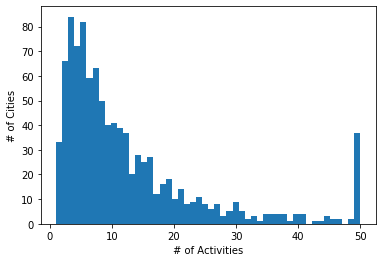

In [6]:
plt.hist(check_num_act,bins=50)
plt.xlabel('# of Activities')
plt.ylabel('# of Cities')
plt.show()

Let's turn this list of cities and activities into a dataframe and then export the file for later use.

In [7]:
columns_df = ['City']
for ii in range(50):
    if len(str(ii+1))<2:
        temp = 'Activity0'+str(ii+1)
    else:
        temp = 'Activity'+str(ii+1)
    columns_df.append(temp)
print(columns_df)

['City', 'Activity01', 'Activity02', 'Activity03', 'Activity04', 'Activity05', 'Activity06', 'Activity07', 'Activity08', 'Activity09', 'Activity10', 'Activity11', 'Activity12', 'Activity13', 'Activity14', 'Activity15', 'Activity16', 'Activity17', 'Activity18', 'Activity19', 'Activity20', 'Activity21', 'Activity22', 'Activity23', 'Activity24', 'Activity25', 'Activity26', 'Activity27', 'Activity28', 'Activity29', 'Activity30', 'Activity31', 'Activity32', 'Activity33', 'Activity34', 'Activity35', 'Activity36', 'Activity37', 'Activity38', 'Activity39', 'Activity40', 'Activity41', 'Activity42', 'Activity43', 'Activity44', 'Activity45', 'Activity46', 'Activity47', 'Activity48', 'Activity49', 'Activity50']


In [8]:
city_table = pd.DataFrame(cities_activities,columns=columns_df)
city_table.head()

,City,Activity01,Activity02,Activity03,Activity04,Activity05,Activity06,Activity07,Activity08,Activity09,...,Activity41,Activity42,Activity43,Activity44,Activity45,Activity46,Activity47,Activity48,Activity49,Activity50
0,Dogville,Food,Hiking,Food,Parks,Beach,Theater,Theater,Food,Parks,...,None,None,None,None,None,None,None,None,None,None
1,Idris,Food,Music,Sports,Music,Theater,Sports,Museums,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Newtropolis,Music,Music,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Greenback,Romantic,Beach,Music,Sports,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Ravnica,Romantic,Theater,Theater,Sports,Sports,Theater,Romantic,Sports,History,...,None,None,None,None,None,None,None,None,None,None


## 2. Creation of users and their history
The idea here is to create a large number of users by choosing a set of cities and activities they previously visited. For each customer, we will randomly pick a number of cities they already visited and select some of the local available activities.

### 2.1 Creating the users
The first idea was to name the users as 'User_#####', but I found a list with the distribution of given names in Brazil, so that will be more interesting. I'm importing the table and will focus only on the names, not the distribution.

In [9]:
user_input = pd.read_csv('ibgenomes.csv')
user_input = user_input.drop(['total','percentual','popularidade'],axis=1)
user_input.dropna(inplace=True)
#user_input = user_input.loc[:int(len(user_input)/4)]

display(user_input.head())
print('Number of users: ',len(user_input))


,Nome
0,MARIA
1,JOSE
2,ANA
3,JOAO
4,ANTONIO


Number of users:  64458


### 2.2 Selecting cities and activities
Now we will create a list with user, city, activity and category. We again use a lognormal distribution to choose the number of cities visited by each user. We randomly select this number of cities. For each city, we count the number of activities available and randomly select how many the user has done, selecting which ones also randomly. 

In [10]:
user_history = []

for name in user_input['Nome'].tolist():
    num_cities = int(np.ceil(np.random.lognormal(.001, 1.)))
    if num_cities>len(city_table):
        num_cities=len(city_table)
    
    city_picks = random.sample(range(len(city_table)),num_cities)    
    for city in city_picks:
        num_act_city = 50-city_table.iloc[city,1:].isnull().sum()
        num_act = random.randint(1,num_act_city)
        act_picks = random.sample(range(num_act_city),num_act)
        for act in act_picks:
            user_history.append([name,city_table.iloc[city,0],columns_df[act+1],city_table.iloc[city,act+1]])

columns_users = ['Name','City','Activity','Category']
user_table = pd.DataFrame(user_history,columns=columns_users)
user_table.head()

,Name,City,Activity,Category
0,MARIA,Spoonerville,Activity04,Parks
1,MARIA,Spoonerville,Activity03,Sports
2,MARIA,Spoonerville,Activity02,Museums
3,JOSE,Elwood City,Activity02,Romantic
4,ANA,Zanaris,Activity07,Parks


## 3. Comparing cities
From our table with the activities for each city, we will create a new table where each row represents a city and each column shows the proportion of its activities for each category. For a city with a single 'Hiking' activity, its row will have *1* in the 'Hiking' column. If a city has three activities ('Museums', 'Romantic', Ḿuseums'), it will have *0.67* in the 'Museums' column and *0.33* in the 'Romantic' one. <br>
With this, we will have a vector describing each city and we can measure the similarities between two cities by the cosine similarity between their rows.

In [11]:
city_vector = city_table.apply(pd.Series.value_counts, axis=1)[categories].fillna(0)
city_vector = city_vector.div(city_vector.sum(axis=1), axis=0)
city_vector.insert(0, 'City', city_table['City'])
city_vector.head()

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,Dogville,0.157895,0.105263,0.000000,0.105263,0.157895,0.105263,0.052632,0.052632,0.105263,0.157895
1,Idris,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.285714,0.142857,0.285714
2,Newtropolis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
3,Greenback,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.250000,0.000000,0.250000
4,Ravnica,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.111111,0.000000,0.333333,0.333333


In [12]:
for ii in range(2):
    city_picks = random.sample(range(len(city_vector)),2)
    display(city_vector[city_vector.index.isin(city_picks)])
    print('Cosine similarity between ',city_vector.iloc[city_picks[0],0],'and ',city_vector.iloc[city_picks[1],0],'is ',float(cosine_similarity([city_vector.iloc[city_picks[0],1:]],[city_vector.iloc[city_picks[1],1:]])))

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
742,Ashton,0.0,0.0,0.100000,0.200000,0.100000,0.100000,0.300000,0.1,0.1,0.0
865,Metro City,0.0,0.0,0.166667,0.333333,0.166667,0.166667,0.166667,0.0,0.0,0.0


Cosine similarity between  Metro City and  Ashton is  0.8333333333333333


,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
24,Fairvale,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.166667,0.333333,0.000000,0.166667
803,Mugsborough,0.142857,0.0,0.142857,0.000000,0.285714,0.0,0.142857,0.000000,0.142857,0.142857


Cosine similarity between  Mugsborough and  Fairvale is  0.21081851067789192


What we want is to find the cities with the highest cosine similarity to our target. So let's try to find the cities most similar to our first city.

In [13]:
corr_df = pd.DataFrame(columns=['City','Similarity'])
corr_df['City'] = city_vector['City']
for ii in range(len(city_vector)):
    corr_df.iloc[ii,1] = float(cosine_similarity([city_vector.iloc[0,1:]],[city_vector.iloc[ii,1:]]))
corr_df = corr_df.sort_values(by='Similarity',ascending=False)
corr_df[corr_df['Similarity']>0.9]

,City,Similarity
0,Dogville,1
712,Mido,0.967037
467,New York City,0.957841
760,Wellsville,0.95758
570,Hyrule,0.955556
173,Newford,0.942596
974,Chronopolis,0.934199
69,Sheepridge,0.931594
869,New Quahog,0.928344
625,Digitopolis,0.923154


We now have the list of the cities most similar to our first city. We can confirm this by displaying the vectors of those cities.

In [14]:
city_picks = corr_df[corr_df['Similarity']>0.9].index
display(city_vector[city_vector.index.isin(city_picks)])

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,Dogville,0.157895,0.105263,0.000000,0.105263,0.157895,0.105263,0.052632,0.052632,0.105263,0.157895
69,Sheepridge,0.205128,0.102564,0.025641,0.102564,0.051282,0.102564,0.076923,0.076923,0.128205,0.128205
82,Frostbite Falls,0.140000,0.060000,0.060000,0.140000,0.060000,0.140000,0.120000,0.040000,0.080000,0.160000
173,Newford,0.111111,0.088889,0.088889,0.111111,0.155556,0.088889,0.066667,0.044444,0.133333,0.111111
200,Collinsport,0.060606,0.121212,0.060606,0.090909,0.181818,0.151515,0.060606,0.090909,0.060606,0.121212
303,Highland,0.100000,0.100000,0.066667,0.100000,0.133333,0.100000,0.133333,0.066667,0.100000,0.100000
324,Zaira,0.117647,0.000000,0.058824,0.058824,0.176471,0.117647,0.117647,0.058824,0.117647,0.176471
395,Traverse Town,0.100000,0.100000,0.050000,0.100000,0.050000,0.150000,0.050000,0.100000,0.150000,0.150000
467,New York City,0.142857,0.142857,0.000000,0.142857,0.142857,0.142857,0.000000,0.000000,0.142857,0.142857
570,Hyrule,0.157895,0.157895,0.052632,0.105263,0.157895,0.105263,0.000000,0.052632,0.105263,0.105263


## 4. Comparing users
From our table with the activities for each user, we will create a new table where each row represents a user and each column shows the proportion of its activities for each category. For a user with a single 'Hiking' activity, its row will have *1* in the 'Hiking' column. If a user has three activities ('Museums', 'Romantic', Ḿuseums'), it will have *0.67* in the 'Museums' column and *0.33* in the 'Romantic' one. We will group the activities from all visited cities.<br>
With this, we will have a vector describing each user and we can measure the similarities between two users by the correlation between their rows.

In [15]:
user_vector = pd.DataFrame(np.zeros((len(user_input),11)),columns = ['Name']+categories)
user_vector['Name'] = user_input['Nome'].tolist()
user_vector = user_vector.set_index('Name')
for ii in range(len(user_table)):
    user_vector.loc[user_table.iloc[ii,0],user_table.iloc[ii,-1]] +=1
user_vector = user_vector.div(user_vector.sum(axis=1), axis=0)
user_vector.reset_index(inplace=True)
user_vector.head()


,Name,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,MARIA,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
1,JOSE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2,ANA,0.105263,0.263158,0.157895,0.000000,0.157895,0.000000,0.000000,0.105263,0.157895,0.052632
3,JOAO,0.142857,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.285714,0.285714
4,ANTONIO,0.052632,0.105263,0.052632,0.052632,0.000000,0.210526,0.315789,0.052632,0.105263,0.052632


In [16]:
for ii in range(2):
    user_picks = random.sample(range(len(user_vector)),2)
    display(user_vector[user_vector.index.isin(user_picks)])
    print('Cosine similarity between ',user_vector.iloc[user_picks[0],0],'and ',user_vector.iloc[user_picks[1],0],'is ',float(cosine_similarity([user_vector.iloc[user_picks[0],1:]],[user_vector.iloc[user_picks[1],1:]])))

,Name,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
26214,SAMYLE,0.076923,0.0,0.153846,0.076923,0.076923,0.076923,0.153846,0.307692,0.000,0.076923
56792,DAPHINNY,0.000000,0.0,0.000000,0.375000,0.125000,0.000000,0.125000,0.125000,0.125,0.125000


Cosine similarity between  SAMYLE and  DAPHINNY is  0.5459208336840117


,Name,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
23038,NIQUELI,0.0,0.0,0.166667,0.0,0.166667,0.0,0.333333,0.0,0.166667,0.166667
25522,MARILINDA,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000


Cosine similarity between  MARILINDA and  NIQUELI is  0.35355339059327373


What we want is to find the users with the highest cosine similarity to our target. So let's try to find the users most similar to our first user.

In [17]:
corr_user_df = pd.DataFrame(columns=['Name','Similarity'])
corr_user_df['Name'] = user_input['Nome']
target_vector = [user_vector.iloc[0,1:]]
for ii in range(len(user_vector)):
    corr_user_df.iloc[ii,1] = float(cosine_similarity(target_vector,[user_vector.iloc[ii,1:]]))
corr_user_df = corr_user_df.sort_values(by='Similarity',ascending=False)
corr_user_df[corr_user_df['Similarity']>0.9].head()

,Name,Similarity
0,MARIA,1
53634,GIOVNNA,1
36407,VESPAZIANO,1
31049,MACRINA,1
36962,HENRYQUE,1


We now have the list of the users most similar to our first user. We can confirm this by displaying the vectors of those users.

In [18]:
user_picks = corr_user_df[corr_user_df['Similarity']>0.9].index
display(user_vector[user_vector.index.isin(user_picks)].head())

,Name,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,MARIA,0.0,0.333333,0.333333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333
2911,FRANCELINA,0.0,0.250000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.250000
3631,LUCIAN,0.0,0.333333,0.333333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333
3781,CLAUDEMIRO,0.0,0.333333,0.250000,0.083333,0.083333,0.083333,0.0,0.0,0.0,0.166667
4313,BRANCA,0.0,0.250000,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.500000


## 5. Comparing users and cities
We now have vectors representing each city and user, with their ratio of categories. We can find the cities that best match a user and vice versa. 

### 5.1 Finding cities matching an user
We will give an example by finding cities that are similar to the behavior of our first user.

In [19]:
corr_user_cities_df = pd.DataFrame(columns=['City','Similarity'])
corr_user_cities_df['City'] = city_vector['City']
target_vector = [user_vector.iloc[0,1:]]
for ii in range(len(city_vector)):
    corr_user_cities_df.iloc[ii,1] = float(cosine_similarity(target_vector,[city_vector.iloc[ii,1:]]))
corr_user_cities_df[corr_user_cities_df['Similarity']>0.9].sort_values(by='Similarity',ascending=False)

,City,Similarity


In [20]:
display(user_vector[user_vector.index==0])
user_cities_picks = corr_user_cities_df[corr_user_cities_df['Similarity']>0.9].index
display(city_vector[city_vector.index.isin(user_cities_picks)])

,Name,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,MARIA,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333


,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports


### 5.2 Finding users matching a city
We will give an example by finding users that are similar to the behavior of our first city.

In [21]:
corr_city_users_df = pd.DataFrame(columns=['Name','Similarity'])
corr_city_users_df['Name'] = user_input['Nome']
target_vector = [city_vector.iloc[0,1:]]
for ii in range(len(user_vector)):
    corr_city_users_df.iloc[ii,1] = float(cosine_similarity(target_vector,[user_vector.iloc[ii,1:]]))
corr_city_users_df = corr_city_users_df.sort_values(by='Similarity',ascending=False)
corr_city_users_df[corr_city_users_df['Similarity']>0.9].head()

,Name,Similarity
57253,ROSILEIDI,1
2585,ADIEL,0.989762
37123,IUDSON,0.987597
3141,MAIQUE,0.98344
11142,ELION,0.982708


In [22]:
display(city_vector[city_vector.index==0])
city_users_picks = corr_city_users_df[corr_city_users_df['Similarity']>0.9].index
display(user_vector[user_vector.index.isin(city_users_picks)].head())

,City,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
0,Dogville,0.157895,0.105263,0.0,0.105263,0.157895,0.105263,0.052632,0.052632,0.105263,0.157895


,Name,Food,Parks,Museums,Hiking,Beach,Romantic,History,Music,Theater,Sports
12,LUIS,0.090909,0.090909,0.045455,0.090909,0.136364,0.181818,0.090909,0.045455,0.136364,0.090909
19,EDUARDO,0.210526,0.157895,0.000000,0.052632,0.157895,0.105263,0.000000,0.105263,0.105263,0.105263
22,RODRIGO,0.073171,0.073171,0.048780,0.097561,0.121951,0.097561,0.073171,0.121951,0.146341,0.146341
33,GUSTAVO,0.142857,0.142857,0.000000,0.000000,0.214286,0.071429,0.071429,0.000000,0.142857,0.214286
48,SEBASTIAO,0.095238,0.107143,0.083333,0.059524,0.154762,0.107143,0.107143,0.059524,0.107143,0.119048


## 6 City Suggestions
For a selected user, we want to make recommendations of cities that match their history and try to rank them. 

### 6.1 Cosine Similarity
The first option is finding cities by similarity with the user vector (done in section 5.1). Another option is to find the users that have the highest cosine similarity (section 4) and find the city that is most common among them.

Let's build upon we have done in section 4 and try to find the cities visited by those users.

In [23]:
corr_user_df[corr_user_df['Similarity']>0.9].head()

,Name,Similarity
0,MARIA,1
53634,GIOVNNA,1
36407,VESPAZIANO,1
31049,MACRINA,1
36962,HENRYQUE,1


We want to create a list of cities visited by these users and how many times each one was visited. We will remove any cities that were already visited by our target.

In [24]:
list_corr_names = corr_user_df[corr_user_df['Similarity']>0.9]['Name'].tolist()
user_table_filtered = user_table[user_table['Name'].isin(list_corr_names)]
list_corr_cities = []
list_target = user_table_filtered[user_table_filtered['Name']==user_vector.iloc[0,0]]['City'].unique().tolist()
for name in list_corr_names:
    if user_vector[user_vector['Name']==name].index != 0:
        temp = user_table_filtered[user_table_filtered['Name']==name]['City'].unique().tolist()
        list_corr_cities += list(set(temp)-set(list_target))

count_corr_cities = {i:list_corr_cities.count(i) for i in list_corr_cities}
max_value = max(count_corr_cities.values()) 
if max_value > 1:
    sugg_cities = [k for k, v in count_corr_cities.items() if v == max_value]
    
else:
    sugg_cities = count_corr_cities.keys

print('List of cities:', sugg_cities,'with', max_value,'occurence(s).')   


List of cities: ["Sleeping Beauty's Castle"] with 5 occurence(s).


Let's check the cosine similarity of these cities with our target user.

In [25]:
corr_user_cities_test_df = pd.DataFrame(columns=['City','Similarity'])
city_vector_filtered = city_vector[city_vector['City'].isin(sugg_cities)]
corr_user_cities_test_df['City'] = city_vector_filtered['City']
target_vector = [user_vector.iloc[0,1:]]
for ii in range(len(city_vector_filtered)):
    corr_user_cities_test_df.iloc[ii,1] = float(cosine_similarity(target_vector,[city_vector_filtered.iloc[ii,1:]]))
corr_user_cities_test_df = corr_user_cities_test_df.sort_values(by='Similarity',ascending=False)
corr_user_cities_test_df

,City,Similarity
65,Sleeping Beauty's Castle,0.870388


Let's compare with cities that matched our user.

In [26]:
corr_user_cities_df[corr_user_cities_df['Similarity']>0.9]

,City,Similarity


### 6.2 Association Rule Learning - *A Priori*

For this approach, we will try to extract knowledge from the user database. Let's try to create rules of association of the kind "*People who visited the city A should also visit city B.*" We are going to use the library **apyori**, but we need to work on our user data.

Our input data needs to be a list where each component is the list of cities visited by the users.

In [27]:
list_cities_visited = []
temp = [user_table.iloc[0,1]]
for ii in range(1,len(user_table)):
    if user_table.iloc[ii,0] == user_table.iloc[ii-1,0]:
        temp += [user_table.iloc[ii,1]]
    else:
        list_cities_visited.append(list(set(temp)))
        temp=[user_table.iloc[ii,1]]
list_cities_visited.append(list(set(temp)))
list_cities_visited[:10]

[['Spoonerville'],
 ['Elwood City'],
 ['Arkham', 'Zanaris', 'Sto Lat'],
 ['Damon'],
 ['Mayberry', 'Springfield', 'Shermer'],
 ['Puddleby-on-the-Marsh', 'San Mondell', 'Vermilion Sands'],
 ['Shire', 'Domain', 'Castle Revolving'],
 ['Radiant City', "Baldur's Gate"],
 ['Ruto'],
 ['Stackton Tressel']]

Now we run the association rule algorithm based on the above list and get the relationship between two different cities.

In [28]:
rules = apriori(transactions=list_cities_visited, min_support=1e-10, min_confidence=1e-10, min_lift=1.00001, min_length=2, max_length=2)

In [29]:
results = list(rules)

def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs,rhs,supports,confidences,lifts))

results_df = pd.DataFrame(inspect(results), columns=['City1', 'City2', 'Support', 'Confidence','Lift'])


In [30]:
print('Number of associations:', len(results_df))
results_df.head()

Number of associations: 192311


,City1,City2,Support,Confidence,Lift
0,ACDC Town,Acme Acres,0.000016,0.008065,3.686685
1,ACDC Town,Addley,0.000031,0.016129,6.707388
2,ACDC Town,Aincrad,0.000016,0.008065,3.635123
3,ACDC Town,Air Temple,0.000016,0.008065,3.609879
4,ACDC Town,Al Khali,0.000016,0.008065,3.609879


Let's check what cities are suggested by the algorithm for the first city, sorted by how strong this reccomendation is.

In [31]:
results_df[results_df['City1']==city_vector.iloc[0,0]].sort_values(by='Lift',ascending=False).head(5)

,City1,City2,Support,Confidence,Lift
80377,Dogville,Hensonville,0.000062,0.029851,14.359100
80520,Dogville,Santa Mira,0.000047,0.022388,10.610953
80481,Dogville,Plant,0.000047,0.022388,9.884175
80461,Dogville,Oakmoor Crossing,0.000047,0.022388,9.816936
80427,Dogville,Mariposa,0.000047,0.022388,9.750605


This output extracts the relation between two cities based on the user data. We don't have data covering all possible pairs of cities.

### 6.3 Final Approach
What we expect from our algorithm is to get five new cities that an user should consider visiting based on his/her history and the data from all users.<br>
For that specific user, we retrieve the list of cities visited and filter the results of our association rule learning. We sort them by *Lift* and present the five cities with the highest score, checking for repeated results. <br>
We might have special cases where we don't have five cities in our results. To complete our list, we will go back to our simpler correlation system, with the cities with largest correlation to the user that are not already on the list.

## 7 Activities recommendation
For each of the cities on our suggestion list, we will use the association rule learning to show us five activites that best match our user's past experiences.<br>
Let's try to create rules of association of the kind "People who visited the atraction X in city A should also visit atraction Y in city B." Again, we need to work on our user data.

In [32]:
user_table['City-Act'] = user_table['City']+' - '+user_table['Activity']
list_act_visited = []
temp = [user_table.iloc[0,-1]]
for ii in range(1,len(user_table)):
    if user_table.iloc[ii,0] == user_table.iloc[ii-1,0]:
        temp += [user_table.iloc[ii,-1]]
    else:
        list_act_visited.append(list(set(temp)))
        temp=[user_table.iloc[ii,-1]]
list_act_visited.append(list(set(temp)))
list_act_visited[:4]

[['Spoonerville - Activity04',
  'Spoonerville - Activity03',
  'Spoonerville - Activity02'],
 ['Elwood City - Activity02'],
 ['Arkham - Activity07',
  'Sto Lat - Activity02',
  'Sto Lat - Activity03',
  'Arkham - Activity10',
  'Zanaris - Activity07',
  'Arkham - Activity01',
  'Arkham - Activity06',
  'Sto Lat - Activity05',
  'Zanaris - Activity09',
  'Arkham - Activity09',
  'Arkham - Activity04',
  'Zanaris - Activity03',
  'Sto Lat - Activity06',
  'Arkham - Activity03',
  'Sto Lat - Activity04',
  'Sto Lat - Activity01',
  'Arkham - Activity08',
  'Zanaris - Activity02',
  'Arkham - Activity02'],
 ['Damon - Activity13',
  'Damon - Activity15',
  'Damon - Activity05',
  'Damon - Activity11',
  'Damon - Activity02',
  'Damon - Activity16',
  'Damon - Activity09']]

Now we run the association rule algorithm based on the above list and get the relationship between two different activities.

In [33]:
rules_act = apriori(transactions=list_act_visited, min_support=1e-10, min_confidence=1e-10, min_lift=1.00001, min_length=2, max_length=2)
results_act = list(rules_act)
results_act_df = pd.DataFrame(inspect(results_act), columns=['Activity1', 'Activity2', 'Support', 'Confidence','Lift'])
results_act_df[['City2','Activity2']] = results_act_df['Activity2'].str.split(" - ",expand=True)
results_act_df = results_act_df[['Activity1','City2','Activity2','Support', 'Confidence', 'Lift']]

In [34]:
display(len(results_act_df))
results_act_df.head()

10315297

,Activity1,City2,Activity2,Support,Confidence,Lift
0,ACDC Town - Activity01,ACDC Town,Activity02,0.000776,0.735294,607.635747
1,ACDC Town - Activity01,ACDC Town,Activity03,0.000745,0.705882,659.416880
2,ACDC Town - Activity01,ACDC Town,Activity04,0.000760,0.720588,663.538235
3,ACDC Town - Activity01,ACDC Town,Activity05,0.000714,0.676471,589.242448
4,ACDC Town - Activity01,ACDC Town,Activity06,0.000698,0.661765,576.432830


Let's check what activities are suggested by the algorithm for the first activity of the first user, sorted by how strong this reccomendation is.

In [35]:
results_act_df[results_act_df['Activity1']==user_table.iloc[0,1]+' - '+user_table.iloc[0,2]].sort_values(by='Lift',ascending=False).head()

,Activity1,City2,Activity2,Support,Confidence,Lift
10018348,Spoonerville - Activity04,Twin Peaks,Activity05,0.000031,0.023810,19.931354
10018352,Spoonerville - Activity04,Twin Peaks,Activity09,0.000031,0.023810,19.426763
10018350,Spoonerville - Activity04,Twin Peaks,Activity07,0.000031,0.023810,17.845515
10018443,Spoonerville - Activity04,Winter River,Activity01,0.000031,0.023810,15.502165
10018293,Spoonerville - Activity04,The City of Light,Activity03,0.000016,0.011905,13.462406


For the activities, we won't complete the list if there are less than five.

In [36]:
results_act_df.sort_values(by='Lift',ascending=False).tail()

,Activity1,City2,Activity2,Support,Confidence,Lift
7009844,Jump City - Activity01,Oxrun Station,Activity01,0.000016,0.006329,2.632013
3123442,Coolsville - Activity01,vendor,Activity01,0.000016,0.006579,2.585767
8632058,New Kasuto - Activity01,vendor,Activity01,0.000016,0.006579,2.585767
9064691,Oxrun Station - Activity01,vendor,Activity01,0.000016,0.006452,2.535720
7011022,Jump City - Activity01,vendor,Activity01,0.000016,0.006329,2.487573


In [37]:
#user_table.to_csv('user_table_final.csv',sep=';',index=False)
#city_table.to_csv('city_table_final.csv',sep=';',index=False)
#results_df.to_csv('results_df_final.csv',sep=';',index=False)
#results_act_df.to_csv('results_act_df_final.csv',sep=';',index=False)


## 8. Full Recomendation
Before we get to our final answer, where we can select an user and see the recomendations, let's try to get everything in order for a single user.

In [38]:
#my name!
user_target = "RODRIGO"

In [39]:
cities_visited_target = list(set(user_table[user_table['Name']==user_target]['City']))
cities_visited_target

['Nabooru', 'Bönk', 'San Andreas']

In [40]:
cities_suggested_target = results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False)['City2'].tolist()[:5]
results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False).head(10)

,City1,City2,Support,Confidence,Lift
48220,Bönk,Vetusta,0.000062,0.027778,13.069343
48021,Bönk,Liberty City,0.000047,0.020833,11.779605
47905,Bönk,Capitol City,0.000062,0.027778,11.190625
48028,Bönk,London Borough of Canley,0.000047,0.020833,10.829637
48101,Bönk,Pewter City,0.000047,0.020833,10.329808
48129,Bönk,Rimmington,0.000047,0.020833,10.329808
181032,San Andreas,Townsville,0.000047,0.020690,9.952342
180996,San Andreas,Spectre,0.000047,0.020690,9.805984
181054,San Andreas,Wazoo,0.000047,0.020690,9.734407
48173,Bönk,Steel City,0.000047,0.020833,9.730978


Our goal here is to get a list of five cities with the highest *lift* considering the list of cities already visited. We need to be careful to remove our original list and also any duplicates that show up.

In [41]:
max_options = len(set(results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False)['City2'].tolist()))
cities_suggested_target = [i for n, i in enumerate(cities_suggested_target) if i not in cities_suggested_target[:n]]
aux_var = 5
while len(cities_suggested_target)!=5 and len(cities_suggested_target)<max_options:
    cities_suggested_target += results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False).iloc[aux_var,1]
    cities_suggested_target = [i for n, i in enumerate(cities_suggested_target) if i not in cities_suggested_target[:n]]
    aux_var += 1
    
cities_suggested_target

['Vetusta ',
 'Liberty City',
 'Capitol City',
 'London Borough of Canley',
 'Pewter City']

We might not get five cities from this method. To complete our list, we will fill the gap with cities with the highest cosine similarity comparing to our user.

In [42]:
if len(cities_suggested_target)<5:
    target_user_vector = user_vector[user_vector['Name']==user_target]
    
    corr_user_cities_df = pd.DataFrame(columns=['City','Similarity'])
    corr_user_cities_df['City'] = city_vector['City']
    for ii in range(len(city_vector)):
        corr_user_cities_df.iloc[ii,1] = float(cosine_similarity([target_user_vector.iloc[0,1:]],[city_vector.iloc[ii,1:]]))
    
    corr_user_cities_df = corr_user_cities_df.sort_values(by='Similarity',ascending=False)
    
    aux_var = 0
    while (len(cities_suggested_target)<5):
        if not(corr_user_cities_df.iloc[aux_var,0].isin(cities_suggested_target)):
            cities_suggested_target += corr_user_cities_df.iloc[aux_var,0]
        else:
            aux_var += 1
        
cities_suggested_target

['Vetusta ',
 'Liberty City',
 'Capitol City',
 'London Borough of Canley',
 'Pewter City']

We now have our 5 suggestions for cities the user should visit. The next step is to get up to five activities in each city.

In [43]:
activities_visited_user = list(set(user_table[user_table['Name']==user_target]['City-Act']))
activities_visited_user

['San Andreas - Activity14',
 'San Andreas - Activity39',
 'San Andreas - Activity02',
 'San Andreas - Activity09',
 'San Andreas - Activity23',
 'Bönk - Activity08',
 'San Andreas - Activity24',
 'San Andreas - Activity06',
 'San Andreas - Activity42',
 'San Andreas - Activity17',
 'San Andreas - Activity01',
 'San Andreas - Activity03',
 'San Andreas - Activity29',
 'Bönk - Activity03',
 'San Andreas - Activity08',
 'San Andreas - Activity21',
 'San Andreas - Activity07',
 'San Andreas - Activity18',
 'San Andreas - Activity25',
 'San Andreas - Activity43',
 'San Andreas - Activity19',
 'San Andreas - Activity15',
 'San Andreas - Activity38',
 'San Andreas - Activity35',
 'Nabooru - Activity03',
 'Bönk - Activity06',
 'San Andreas - Activity26',
 'Nabooru - Activity01',
 'San Andreas - Activity27',
 'San Andreas - Activity34',
 'San Andreas - Activity16',
 'San Andreas - Activity10',
 'San Andreas - Activity36',
 'San Andreas - Activity37',
 'San Andreas - Activity22',
 'Nabooru - Ac

We have the cities and activities the user has already experienced and our suggested cities. For each new city, we will look for up to five activities that are associated with the past experiences.

In [44]:
final_suggestion_list = pd.DataFrame(columns=cities_suggested_target)
for city in cities_suggested_target:
    max_options_act = len(set(results_act_df[(results_act_df['Activity1'].isin(activities_visited_user)) & (results_act_df['City2']==city)].sort_values(by='Lift',ascending=False)['Activity2'].tolist()))
    aux_list = results_act_df[(results_act_df['Activity1'].isin(activities_visited_user)) & (results_act_df['City2']==city)].sort_values(by='Lift',ascending=False)['Activity2'].tolist()[:5]
    aux_list = [i for n, i in enumerate(aux_list) if i not in aux_list[:n]]

    aux_var = 5
    while len(aux_list)!=5 and len(aux_list)<max_options_act:
        aux_list += [results_act_df[(results_act_df['Activity1'].isin(activities_visited_user)) & (results_act_df['City2']==city)].sort_values(by='Lift',ascending=False)['Activity2'].tolist()[aux_var]]
        aux_var += 1
        aux_list = [i for n, i in enumerate(aux_list) if i not in aux_list[:n]]
    
    while len(aux_list)<5:
        aux_list += ['']
    final_suggestion_list[city] = aux_list
final_suggestion_list

,Vetusta,Liberty City,Capitol City,London Borough of Canley,Pewter City
0,Activity01,Activity04,Activity04,Activity04,Activity03
1,Activity05,Activity01,Activity21,Activity07,Activity06
2,Activity08,Activity02,Activity14,Activity02,Activity02
3,Activity10,Activity03,Activity08,Activity01,Activity05
4,Activity11,,Activity20,,Activity01


## 9. End result
We have now worked through our data and we are ready to define a function that only has one input, the name of the user we are interested. It returns a table with the five cities and up to five activities for each city, strongest recommendation first is both cases.

In [45]:
def make_suggestions(user_target):
    cities_visited_target = list(set(user_table[user_table['Name']==user_target]['City']))
    
    cities_suggested_target = results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False)['City2'].tolist()[:5]
    
    max_options = len(set(results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False)['City2'].tolist()))
    cities_suggested_target = [i for n, i in enumerate(cities_suggested_target) if i not in cities_suggested_target[:n]]
    aux_var = 5
    while len(cities_suggested_target)!=5 and len(cities_suggested_target)<max_options:
        cities_suggested_target += results_df[(results_df['City1'].isin(cities_visited_target)) & ~(results_df['City2'].isin(cities_visited_target))].sort_values(by='Lift',ascending=False).iloc[aux_var,1]
        cities_suggested_target = [i for n, i in enumerate(cities_suggested_target) if i not in cities_suggested_target[:n]]
        aux_var += 1
    
    if len(cities_suggested_target)<5:
        target_user_vector = user_vector[user_vector['Name']==user_target]

        corr_user_cities_df = pd.DataFrame(columns=['City','Similarity'])
        corr_user_cities_df['City'] = city_vector['City']
        for ii in range(len(city_vector)):
            corr_user_cities_df.iloc[ii,1] = float(cosine_similarity([target_user_vector.iloc[0,1:]],[city_vector.iloc[ii,1:]]))

        corr_user_cities_df = corr_user_cities_df.sort_values(by='Similarity',ascending=False)

        aux_var = 0
        while (len(cities_suggested_target)<5):
            if not(corr_user_cities_df.iloc[aux_var,0].isin(cities_suggested_target)):
                cities_suggested_target += corr_user_cities_df.iloc[aux_var,0]
            else:
                aux_var += 1
    
    
    final_suggestion_list_temp = pd.DataFrame(columns=cities_suggested_target)
    
    activities_visited_user = list(set(user_table[user_table['Name']==user_target]['City-Act']))
    for city in cities_suggested_target:
        max_options_act = len(set(results_act_df[(results_act_df['Activity1'].isin(activities_visited_user)) & (results_act_df['City2']==city)].sort_values(by='Lift',ascending=False)['Activity2'].tolist()))
        aux_list = results_act_df[(results_act_df['Activity1'].isin(activities_visited_user)) & (results_act_df['City2']==city)].sort_values(by='Lift',ascending=False)['Activity2'].tolist()[:5]
        aux_list = [i for n, i in enumerate(aux_list) if i not in aux_list[:n]]

        aux_var = 5
        while len(aux_list)!=5 and len(aux_list)<max_options_act:
            aux_list += [results_act_df[(results_act_df['Activity1'].isin(activities_visited_user)) & (results_act_df['City2']==city)].sort_values(by='Lift',ascending=False)['Activity2'].tolist()[aux_var]]
            aux_var += 1
            aux_list = [i for n, i in enumerate(aux_list) if i not in aux_list[:n]]

        new_list = []
        for ii in range(len(aux_list)):
            new_list += [aux_list[ii]+' - '+city_table[(city_table['City']==city)].iloc[0,int(aux_list[ii][-2:])]]
        while len(new_list)<5:
            new_list += ['']
        
        final_suggestion_list_temp[city] = new_list
    
    return final_suggestion_list_temp

In [51]:
make_suggestions('RODRIGO')

,Vetusta,Liberty City,Capitol City,London Borough of Canley,Pewter City
0,Activity01 - Hiking,Activity04 - Parks,Activity04 - Sports,Activity04 - Museums,Activity03 - Hiking
1,Activity05 - Food,Activity01 - Hiking,Activity21 - Beach,Activity07 - Museums,Activity06 - Beach
2,Activity08 - Sports,Activity02 - Parks,Activity14 - Beach,Activity02 - Hiking,Activity02 - Beach
3,Activity10 - Museums,Activity03 - Parks,Activity08 - Romantic,Activity01 - Romantic,Activity05 - Parks
4,Activity11 - Theater,,Activity20 - Food,,Activity01 - Museums


In [52]:
make_suggestions('FILIPE')

,Sera,Walkerville,Townsville,Tomobiki,New Burbage
0,Activity06 - Parks,Activity02 - History,Activity02 - Beach,Activity10 - Beach,Activity08 - Hiking
1,Activity05 - Sports,Activity05 - Music,Activity04 - Museums,Activity12 - Music,Activity09 - Theater
2,Activity03 - Beach,Activity01 - Music,Activity01 - Theater,Activity11 - Parks,Activity11 - Hiking
3,Activity02 - Music,Activity04 - History,Activity10 - Food,Activity09 - Sports,Activity06 - Museums
4,Activity01 - Sports,Activity03 - Food,Activity03 - Parks,Activity02 - Museums,Activity10 - Music


In [53]:
make_suggestions('RAFAELA')

,Transverse City,Tremorton,Watoga,Wellsville,Trost District
0,Activity03 - Music,Activity06 - History,Activity10 - Theater,Activity07 - Beach,Activity04 - Museums
1,Activity04 - Museums,Activity04 - Beach,Activity01 - History,Activity18 - Hiking,Activity07 - Beach
2,Activity02 - Hiking,Activity01 - Sports,Activity15 - Parks,Activity10 - Hiking,Activity06 - History
3,Activity06 - Music,Activity02 - Museums,Activity11 - Food,Activity34 - Music,Activity03 - Romantic
4,,Activity05 - Food,Activity09 - Parks,Activity23 - Romantic,Activity08 - History


In [54]:
make_suggestions('MARCUS')

,Spectre,London Borough of Canley,Sleeping Beauty's Castle,Mudville,Saria
0,Activity03 - Music,Activity06 - Beach,Activity06 - Museums,Activity01 - History,Activity14 - Parks
1,Activity06 - Museums,Activity05 - Food,Activity03 - Parks,Activity03 - Beach,Activity04 - Romantic
2,Activity04 - Music,Activity04 - Museums,Activity07 - Sports,Activity02 - Parks,Activity07 - Museums
3,Activity11 - Beach,Activity03 - Sports,Activity02 - Parks,Activity04 - Beach,Activity08 - Beach
4,Activity05 - Romantic,Activity07 - Museums,Activity01 - Food,,Activity15 - History


In [55]:
make_suggestions('PEDRO')

,Tilbury Town,The Emerald City,Westopolis,Tinny Waters,Tilling
0,Activity06 - Beach,Activity08 - Theater,Activity04 - Music,Activity06 - Theater,Activity04 - Parks
1,Activity03 - Hiking,Activity04 - Music,Activity05 - Romantic,Activity03 - Museums,Activity01 - Beach
2,Activity04 - Hiking,Activity03 - Romantic,Activity01 - Music,Activity05 - Museums,Activity02 - Hiking
3,Activity02 - Theater,Activity06 - Theater,Activity06 - Theater,Activity02 - Beach,Activity05 - Museums
4,Activity05 - History,Activity07 - Theater,Activity03 - Hiking,Activity01 - Beach,
